In [1]:
import pandas as pd
from scipy import stats
import datetime
import rpy2
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ecs_series_1_uid_encoded(1).csv")
datetime_object = datetime.datetime.strptime("9/27/18 16:00", "%m/%d/%y %H:%M")
df['Date'] = df["ds"].apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%y %H:%M"))
df = df.drop(columns = ['ds','region_no_factor','iz_no_factor','product_factor','instance_type_name_factor','instance_type_family_factor'])

In [3]:
df = df.groupby(by=['uid','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'uid',values = 'vcpu_net_delead')

In [22]:
df_recency =  pd.DataFrame(columns = df.columns)
df_monetary =  pd.DataFrame(columns = df.columns)
df_frequency = pd.DataFrame(columns = df.columns)

In [24]:
df_test = df.sample(100)

In [20]:
df_test

Date,2017-01-01 16:00:00,2017-01-02 16:00:00,2017-01-03 16:00:00,2017-01-04 16:00:00,2017-01-05 16:00:00,2017-01-06 16:00:00,2017-01-07 16:00:00,2017-01-08 16:00:00,2017-01-09 16:00:00,2017-01-10 16:00:00,...,2018-11-16 16:00:00,2018-11-17 16:00:00,2018-11-18 16:00:00,2018-11-19 16:00:00,2018-11-20 16:00:00,2018-11-21 16:00:00,2018-11-22 16:00:00,2018-11-23 16:00:00,2018-11-24 16:00:00,2018-11-25 16:00:00
uid,,,,,,,,,,,,,,,,,,,,,
132840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for index, row in df_test.iterrows():
    arr = []
    arr = list(row)
    rec_arr = []
    mon_arr = []
    start_date = row.index[0]
    last_purchase = np.nan
    first_purchase = 0 #flag
    #RECENCY Customer did a explicit activity, such as renting cores or releasing cores.
    for j, entry in enumerate(arr):
        if (np.isnan(entry)):            
            if (first_purchase==0):
                rec_arr.append(row.index[j]-start_date)
            else:
                rec_arr.append(row.index[j]-last_purchase)
        else:
            #not nan
            first_purchase = 1
            rec_arr.append(0)
            last_purchase = row.index[j]
    df_recency.loc[index] = rec_arr
    #FREQUENCY Rolling mean time between purchases
    da = xr.DataArray(arr,coords=[pd.date_range(start_date,row.index[len(arr)-2] ,freq=pd.DateOffset(days=1))],dims='time')
    da = da.rolling(time=2).mean()
    #MONETARY  Moving average monetary value
    current_servers = 0
    total_days_of_purchases = 0 
    for j,entry in enumerate(arr):
        if (np.isnan(entry)):
            total_days_of_purchases+=current_servers
        else:
            current_servers+=entry
            total_days_of_purchases+=current_servers
        mon_arr.append(total_days_of_purchases/(j+1))
    df_monetary.loc[index] = mon_arr


In [7]:
from sklearn.cluster import KMeans 

In [27]:
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(df_monetary)

In [28]:
df_monetary['label'] = labels

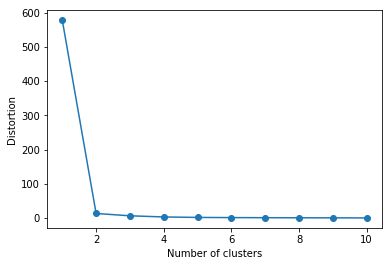

In [26]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,random_state=0)
    km.fit(df_monetary)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show();